# Stage 1 - Setup

In [478]:
import pandas as pd
import numpy as np
import math
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import seaborn as sns

In [479]:
#Read the dataset
data = pd.read_csv('database.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

# Step 2 - Pre processing data

In [480]:
#Drop the ID column
data = data.drop('ID', axis=1)

#Percentage of missing values in each column
data.isna().mean()

Date                          0.000000
Time                          0.000000
Latitude                      0.000000
Longitude                     0.000000
Type                          0.000000
Depth                         0.000000
Depth Error                   0.809457
Depth Seismic Stations        0.696865
Magnitude                     0.000000
Magnitude Type                0.000128
Magnitude Error               0.986033
Magnitude Seismic Stations    0.890484
Azimuthal Gap                 0.688237
Horizontal Distance           0.931488
Horizontal Error              0.950624
Root Mean Square              0.258842
Source                        0.000000
Location Source               0.000000
Magnitude Source              0.000000
Status                        0.000000
dtype: float64

In [481]:
#Drop the columns in which more than 60% of values are missing
number_of_rows = data.shape[0]
droppable_columns = data.isna().sum() > 0.60 * number_of_rows

#Get the names of the columns to drop
droppable_columns_names = data.loc[:, droppable_columns].columns

#Drop the columns from the dataset
data = data.drop(droppable_columns_names, axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              23412 non-null  object 
 1   Time              23412 non-null  object 
 2   Latitude          23412 non-null  float64
 3   Longitude         23412 non-null  float64
 4   Type              23412 non-null  object 
 5   Depth             23412 non-null  float64
 6   Magnitude         23412 non-null  float64
 7   Magnitude Type    23409 non-null  object 
 8   Root Mean Square  17352 non-null  float64
 9   Source            23412 non-null  object 
 10  Location Source   23412 non-null  object 
 11  Magnitude Source  23412 non-null  object 
 12  Status            23412 non-null  object 
dtypes: float64(5), object(8)
memory usage: 2.3+ MB


In [482]:
data.isna().sum()

Date                   0
Time                   0
Latitude               0
Longitude              0
Type                   0
Depth                  0
Magnitude              0
Magnitude Type         3
Root Mean Square    6060
Source                 0
Location Source        0
Magnitude Source       0
Status                 0
dtype: int64

Column 'Root Mean Square' is numeric and has around 26% of missing values. In order to not shrink too much the already shrunk dataset, the missing fields will be completed by inserting the mean of the values in that column

In [483]:
rms_mean = data['Root Mean Square'].mean()
data['Root Mean Square'] = data['Root Mean Square'].fillna(rms_mean)

In column 'Magnitude Type' 3 records have NaN value. These records are discarded.

In [484]:
data = data.dropna(axis=0).reset_index(drop=True)

Insights about the cleaned dataset

In [485]:
print(f"Number of rows: {len(data.index)}")
print(f"Number of rows with NaN: {data.isna().sum().sum()}")

Number of rows: 23409
Number of rows with NaN: 0


# Step 3 - Feature Extraction

From the field 'Date' extract the month and the year, these two features can suggest some patterns due to atmospherical conditions (temperature, humidity).

In [486]:
years = data['Date'].apply(lambda x: x[-4:])

The years retrieved from the column are not all valid, there is some noisy records that are going to be removed

In [487]:
invalid_year_indices = data[years.str.contains('Z')].index
print(f"Number of removed records: {len(invalid_year_indices)}")

Number of removed records: 3


In [488]:
years = years.drop(invalid_year_indices, axis=0)
years = years.astype(int)
data['Years'] = years
data.reset_index(drop=True)

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Root Mean Square,Source,Location Source,Magnitude Source,Status,Years
0,01/02/1965,13:44:18,19.2460,145.6160,Earthquake,131.60,6.0,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0
1,01/04/1965,11:29:49,1.8630,127.3520,Earthquake,80.00,5.8,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0
2,01/05/1965,18:05:58,-20.5790,-173.9720,Earthquake,20.00,6.2,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0
3,01/08/1965,18:49:43,-59.0760,-23.5570,Earthquake,15.00,5.8,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0
4,01/09/1965,13:32:50,11.9380,126.4270,Earthquake,15.00,5.8,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23404,12/28/2016,08:22:12,38.3917,-118.8941,Earthquake,12.30,5.6,ML,0.189800,NN,NN,NN,Reviewed,2016.0
23405,12/28/2016,09:13:47,38.3777,-118.8957,Earthquake,8.80,5.5,ML,0.218700,NN,NN,NN,Reviewed,2016.0
23406,12/28/2016,12:38:51,36.9179,140.4262,Earthquake,10.00,5.9,MWW,1.520000,US,US,US,Reviewed,2016.0
23407,12/29/2016,22:30:19,-9.0283,118.6639,Earthquake,79.00,6.3,MWW,1.430000,US,US,US,Reviewed,2016.0


In [489]:
months = data['Date'].apply(lambda x: x[0:2]).astype(int)
data['Month'] = months

In [490]:
data = data.drop('Date', axis=1)

From the time column extract the hour only

In [491]:
hours = data['Time'].apply(lambda x: int(x[0:2]))
data['Hour'] = hours

In [492]:
data = data.drop('Time', axis=1)

Save all the elements which type is 'Earthquake', discard all the others

In [493]:
types = data['Type']
invalid_type_indices = data[types.apply(lambda x: x != 'Earthquake')].index
types = types.drop(invalid_type_indices, axis=0)
data = data.drop('Type', axis=1)
data.reset_index(drop=True)

data

,Latitude,Longitude,Depth,Magnitude,Magnitude Type,Root Mean Square,Source,Location Source,Magnitude Source,Status,Years,Month,Hour
0,19.2460,145.6160,131.60,6.0,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0,1,13
1,1.8630,127.3520,80.00,5.8,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0,1,11
2,-20.5790,-173.9720,20.00,6.2,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0,1,18
3,-59.0760,-23.5570,15.00,5.8,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0,1,18
4,11.9380,126.4270,15.00,5.8,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23404,38.3917,-118.8941,12.30,5.6,ML,0.189800,NN,NN,NN,Reviewed,2016.0,12,8
23405,38.3777,-118.8957,8.80,5.5,ML,0.218700,NN,NN,NN,Reviewed,2016.0,12,9
23406,36.9179,140.4262,10.00,5.9,MWW,1.520000,US,US,US,Reviewed,2016.0,12,12
23407,-9.0283,118.6639,79.00,6.3,MWW,1.430000,US,US,US,Reviewed,2016.0,12,22


# Step 4 - Visualization of the cleaned dataset

In [494]:
numeric_columns = [column for column in data.columns if data.dtypes[column] != 'object']

#Create the correlation matrix
corr = data[numeric_columns].corr()

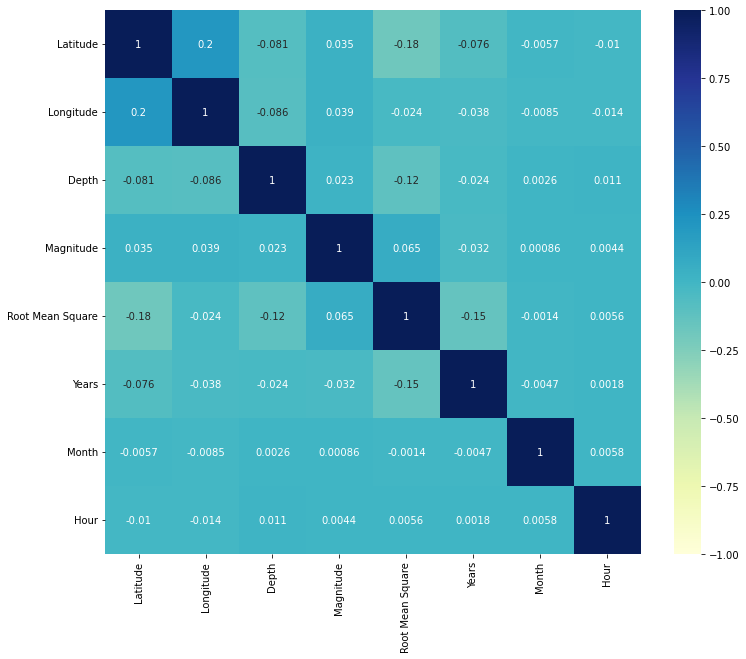

In [495]:
#Print the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, vmax=1.0, cmap="YlGnBu")
plt.show()

# Step 5 - Learning

In [496]:
data

,Latitude,Longitude,Depth,Magnitude,Magnitude Type,Root Mean Square,Source,Location Source,Magnitude Source,Status,Years,Month,Hour
0,19.2460,145.6160,131.60,6.0,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0,1,13
1,1.8630,127.3520,80.00,5.8,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0,1,11
2,-20.5790,-173.9720,20.00,6.2,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0,1,18
3,-59.0760,-23.5570,15.00,5.8,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0,1,18
4,11.9380,126.4270,15.00,5.8,MW,1.022784,ISCGEM,ISCGEM,ISCGEM,Automatic,1965.0,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23404,38.3917,-118.8941,12.30,5.6,ML,0.189800,NN,NN,NN,Reviewed,2016.0,12,8
23405,38.3777,-118.8957,8.80,5.5,ML,0.218700,NN,NN,NN,Reviewed,2016.0,12,9
23406,36.9179,140.4262,10.00,5.9,MWW,1.520000,US,US,US,Reviewed,2016.0,12,12
23407,-9.0283,118.6639,79.00,6.3,MWW,1.430000,US,US,US,Reviewed,2016.0,12,22


Calculating the size of the training and test set:
* Training set 20% of the dimension of the cleaned up collection
* Test set the remaining part (80%) of the collection

In [497]:
m = data.shape[0]
permutation = np.random.permutation(m)

tr_size = math.floor(0.2 * data.shape[0])
test_size = data.shape[0] - tr_size

print(f"Training set size {tr_size}")
print(f"Test set size {test_size}")

Training set size 4681
Test set size 18728
